In [1]:
%matplotlib inline

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from unidecode import unidecode

DATA_EXT = (Path(os.getcwd()) / os.pardir / 'data' / 'external').resolve()

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *
from data.geo_utils import canonicalize_dataframe_geographies

In [3]:
who_df = pd.read_csv(Path('../data/interim/calc_cols_added.csv'), index_col=0)
who_df.head(2)

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing
0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,51.801245,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth
1,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Kamari,1.0,4599.0,NaN,94.674670,4354.088093,Aab Kamari,afghanistan,1,BCG,BCG,1st_birth


In [4]:
code_to_name = (who_df[['Iso Code', 'Country Name']].drop_duplicates()
                                                    .set_index('Iso Code')
                                                    .to_dict()['Country Name'])

### Coefficient of Variation, recalced numerators

In [5]:
# numerator error, adminstered at same time
coef_var = (who_df.groupby(['Iso Code', 'available_admin', 'timing'])
                  .recalc_numerator
                  .agg(['mean', 'std'])
                  .assign(coef_of_var=lambda x: x['std'] / x['mean'])
                  .dropna()
                  .reset_index()
                  .groupby('Iso Code')
                  .coef_of_var
                  .mean()
                  .dropna()
                  .sort_values(ascending=False))

coef_var.to_frame().to_csv(Path('../data/processed/scores/country-internal-coef_of_var.csv'))

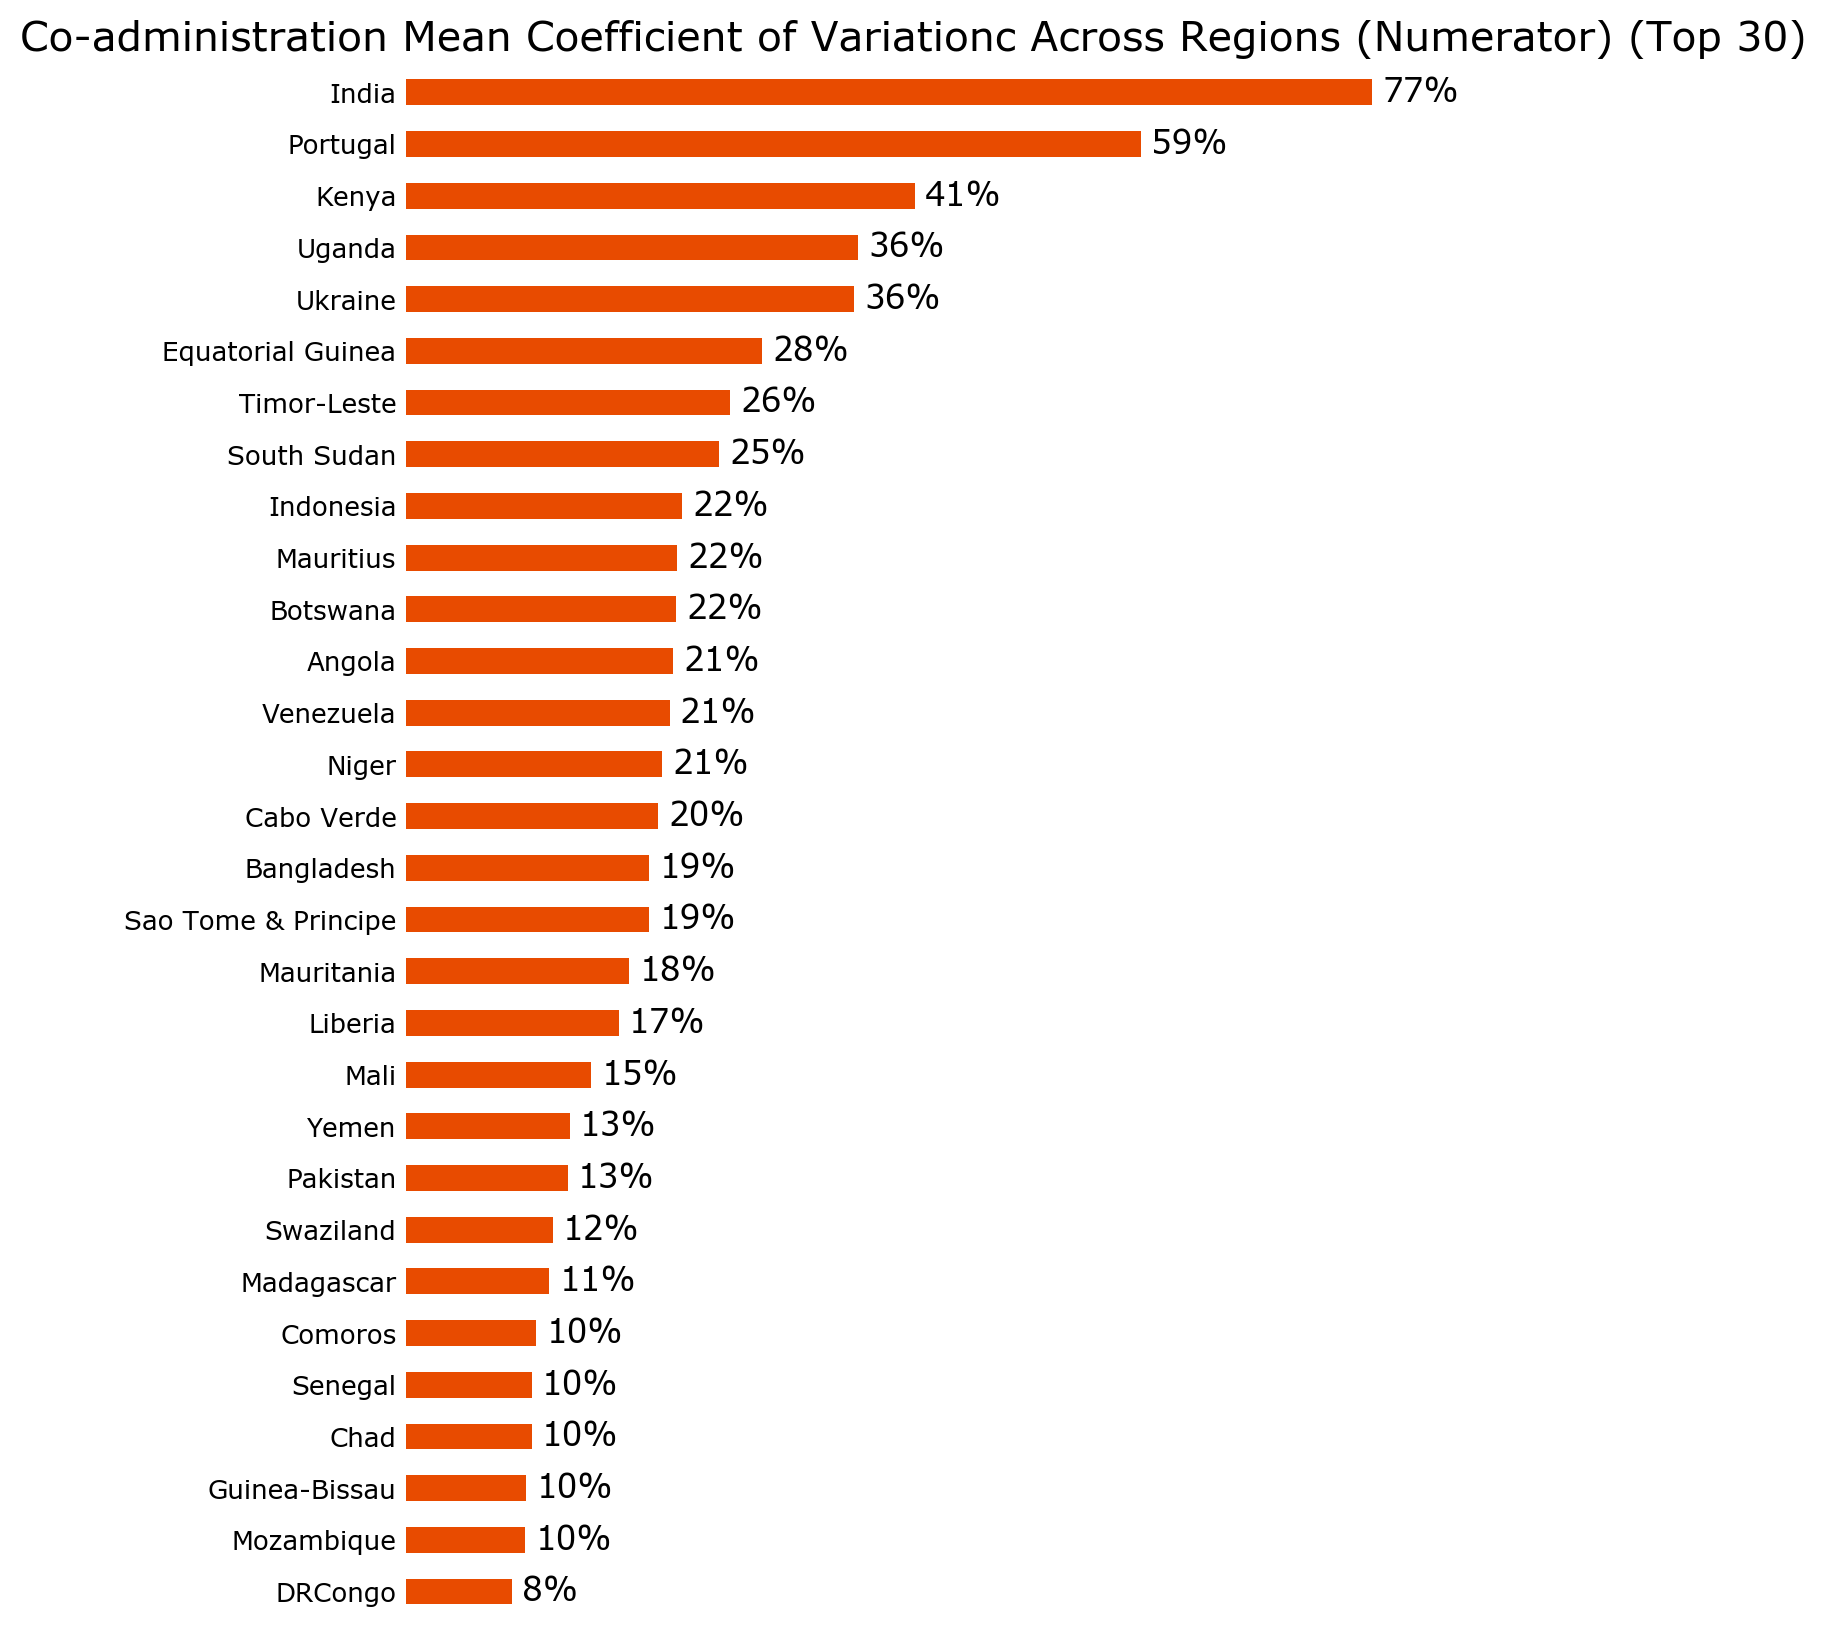

In [6]:
to_plot = coef_var
PLOT_LIM = 30
FS=12

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values().rename(index=code_to_name),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Co-administration Mean Coefficient of Variationc Across Regions (Numerator) (Top {})'.format(PLOT_LIM))

### Coefficient of Variation Denoms

In [8]:
# numerator error, adminstered at same time
coef_var = (who_df.groupby(['Iso Code', 'available_admin', 'timing'])
                  .Denominator
                  .agg(['mean', 'std'])
                  .assign(coef_of_var=lambda x: x['std'] / x['mean'])
                  .dropna()
                  .reset_index()
                  .groupby('Iso Code')
                  .coef_of_var
                  .mean()
                  .dropna()
                  .sort_values(ascending=False))

coef_var.name = 'coef_of_var_denom'
coef_var.to_frame().to_csv(Path('../data/processed/scores/country-internal-coef_of_var_denom.csv'))

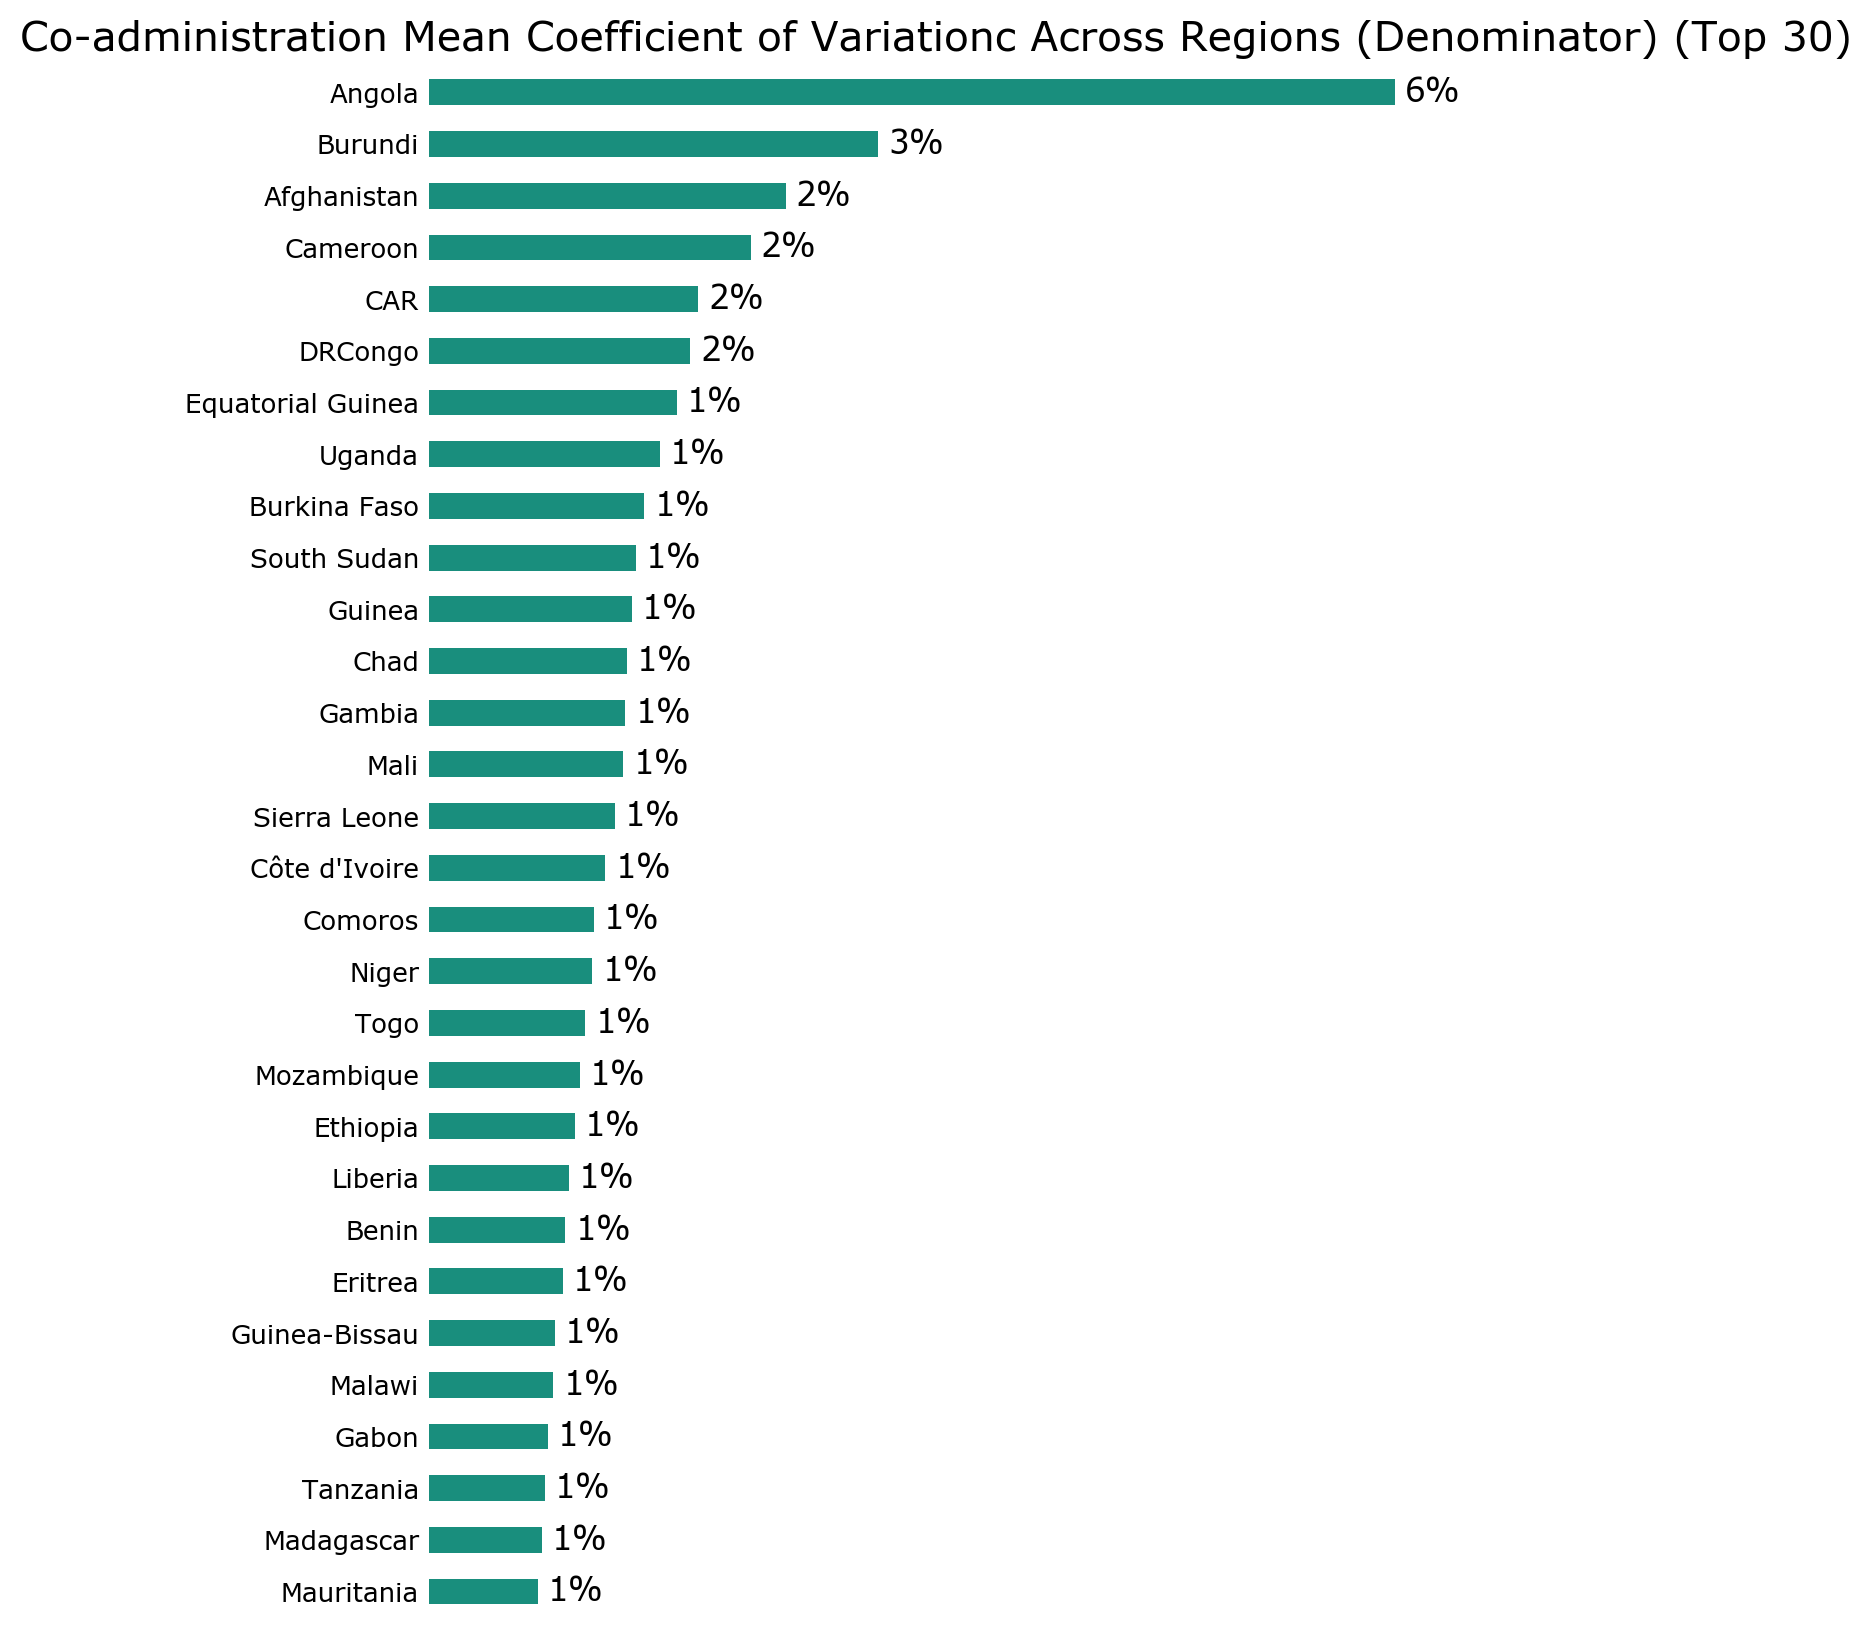

In [9]:
to_plot = coef_var
PLOT_LIM = 30
FS=12

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values().rename(index=code_to_name),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['green']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Co-administration Mean Coefficient of Variationc Across Regions (Denominator) (Top {})'.format(PLOT_LIM))

### DTP Dropout - Averaged

In [12]:
dtp_dropout = who_df[who_df['Vaccine Type'].isin(['DTP1', 'DTP3'])]

dropout_averaged = (dtp_dropout.groupby(['Iso Code', 'available_admin', 'Vaccine Type'])
                                .agg({
                                    'recalc_numerator': 'first',
                                    'Denominator': 'first'
                                })
                                .assign(coverage=lambda x: x.recalc_numerator / x.Denominator)
                                .coverage
                                .unstack(-1)
                                .pipe(lambda x: 100 * (x.DTP1 - x.DTP3) / x.DTP1)
                                .abs()
                                .reset_index()
                                .groupby('Iso Code')
                                .mean()
                                [0])

dropout_averaged.name = 'dropout_averaged'
dropout_averaged.to_frame().to_csv(Path('../data/processed/scores/country-internal-dtp-dropout-averaged.csv'))




### DTP Dropout aggregated

In [13]:
dtp_dropout = who_df[who_df['Vaccine Type'].isin(['DTP1', 'DTP3'])]

dropout_agg = (dtp_dropout.groupby(['Iso Code', 'Vaccine Type'])
                                .agg({
                                    'recalc_numerator': 'sum',
                                    'Denominator': 'sum'
                                })
                                .pipe(lambda x: x.recalc_numerator / x.Denominator)
                                .unstack(-1)
                                .pipe(lambda x: 100 * (x.DTP1 - x.DTP3) / x.DTP1))


dropout_agg.name = 'dropout_aggregated'
dropout_agg.to_frame().to_csv(Path('../data/processed/scores/country-internal-dtp-dropout-agg.csv'))

### MCV Dropout (UNUSED)

In [ ]:
dropout = who_df[who_df['Vaccine Type'].isin(['MCV1', 'MCV2'])]

dtp_counts = (dropout.groupby(['Country Name', 'available_admin', 'Vaccine Type'])
        .recalc_numerator
        .first()
        .unstack(-1))

dropout_count = (dtp_counts
        .diff(axis=1)
        .MCV2)


mean_dropout2 = (dropout_count.divide(dtp_counts.MCV1)
                             .replace({np.inf: np.nan})
                             .dropna().abs().groupby('Country Name').mean().sort_values(ascending=False))


to_plot = mean_dropout2

PLOT_LIM = 50

with styled_fig_ax(size='tall', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Mean Absolute Change MCV1 to MCV2, as percent of MCV2 (top {})'.format(PLOT_LIM))
    





In [ ]:
samesies = np.intersect1d(mean_dropout.index.values, mean_dropout2.index.values)

pd.DataFrame({
    'rank_dtp': mean_dropout[samesies].rank(ascending=False),
    'rank_mcv': mean_dropout2[samesies].rank(ascending=False)
}).mean(axis=1).sort_values()
